In [218]:
import sys
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.options import args_parser
from utils.utils import exp_details, get_model
from utils.label_distribution_dataset import LabelDistributionDataset
from utils.accs import train_models

In [219]:
args = args_parser(default=True)

args.local_ep = 1
args.local_bs = 32
args.supervision = True

args.lr = 1e-3
args.dataset = "cifar"
args.arch = "cnn"

# args.lr = 1e-4
# args.dataset = "mnist"
# args.arch = "mlp"

exp_details(args)


Experimental details:

Reinforcement Arguments:
    Steps Before PPO Update : 256
    PPO Learning Rate       : 0.0003
    PPO Discount Factor     : 0.9
    PPO Batch Size          : 16
    PPO Total Timesteps     : 15000
    Target Accuracy         : 0.95

Federated Arguments:
    Number of Users         : 100
    Fraction of Users       : 0.1
    Local Epochs            : 1
    Local Batch Size        : 32
    Learning Rate           : 0.001
    Momentum                : 0.5
    Optimizer               : adam

Model Arguments:
    Supervision             : True
    Architecture            : cnn

Misc. Arguments:
    Dataset                 : cifar
    Number of GPUs          : 1
    IID                     : 0
    Random Seed             : 1
    Test Fraction           : 1
    Save Path               : ../../save
    Data Path               : ../../data



In [220]:
base_model = get_model(args.arch, args.dataset, "cpu")
base_model_path = os.path.join(args.data_path, f"base_model_{args.dataset}_{args.arch}.pth")
torch.save(base_model, base_model_path)

In [221]:
noise_type = "laplacian"
noise_scale = 1e-3

train_dataset = LabelDistributionDataset(args.dataset, args.local_ep, args.local_bs, args.lr, args.optimizer, args.supervision, True, args.data_path, base_model_path, "cuda", noise_type, noise_scale)
test_dataset = LabelDistributionDataset(args.dataset, args.local_ep, args.local_bs, args.lr, args.optimizer, args.supervision, False, args.data_path, base_model_path, "cuda", noise_type, noise_scale)

Loading from saved dataset...
Loading dataset...
Loading from saved dataset...
Loading dataset...


In [222]:
print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    break

Number of samples in train set: 10000
Number of samples in test set: 2000
Shape of X: torch.Size([32, 10])
Shape of y: torch.Size([32, 10])


In [223]:
class DistributionPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(10, 1000)
        self.hidden_layers = nn.ModuleList()
        for i in range(8):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(1000, 1000),
                nn.ReLU(),
            ))
        self.output_layer = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

In [224]:
def train(dataloader, model, loss_fn, optimizer, device):
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss
    train_loss /= num_batches
    return train_loss.item()


def test(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return test_loss

In [225]:
device = "cuda"

model_save_path = os.path.join(args.save_path, "distribution_prediction", f"distribution_predictor_model_{args.dataset}_{args.arch}_{noise_type}_{noise_scale}.pth")

model = DistributionPredictor()
model.to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

train_losses = []
test_losses = []

epochs = 500
for t in tqdm(range(epochs)):
    test_loss = test(test_dataloader, model, loss_fn, device)
    test_losses.append(test_loss)
    train_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    train_losses.append(train_loss)

print("Done!")
print(f"Final test loss: {test_losses[-1]:.5f}")
print(f"Final train loss: {train_losses[-1]:.5f}")

torch.save(model, model_save_path)

DistributionPredictor(
  (input_layer): Linear(in_features=10, out_features=1000, bias=True)
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (6): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (7): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): R

100%|██████████| 500/500 [10:03<00:00,  1.21s/it]

Done!
Final test loss: 0.00078
Final train loss: 0.00005


In [226]:
np.save(os.path.join(args.save_path, "distribution_prediction", f"train_losses_{args.dataset}_{args.arch}_{noise_type}_{noise_scale}.npy"), train_losses)
np.save(os.path.join(args.save_path, "distribution_prediction", f"test_losses_{args.dataset}_{args.arch}_{noise_type}_{noise_scale}.npy"), test_losses)

In [227]:
train_losses = np.load(os.path.join(args.save_path, "distribution_prediction", f"train_losses_{args.dataset}_{args.arch}_{noise_type}_{noise_scale}.npy"))
test_losses = np.load(os.path.join(args.save_path, "distribution_prediction", f"test_losses_{args.dataset}_{args.arch}_{noise_type}_{noise_scale}.npy"))

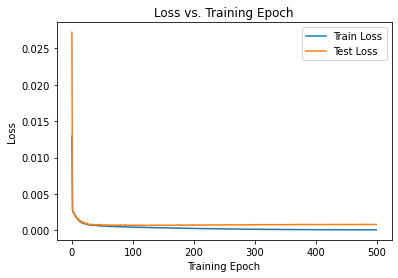

In [228]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")

plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Training Epoch")
plt.legend()
plt.show()

In [229]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
model = torch.load(model_save_path)
model.eval()

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        for a, b in zip(pred.cpu().numpy(), y.cpu().numpy()):
            print(a, b)
        break

[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00]
[0.18 0.79 0.01 0.00 0.00 0.01 0.01 0.00 0.00 0.00] [0.16 0.83 0.00 0.00 0.00 0.00 0.02 0.00 0.00 0.00]
[0.12 0.10 0.06 0.06 0.11 0.12 0.14 0.12 0.09 0.09] [0.10 0.09 0.08 0.09 0.10 0.11 0.11 0.11 0.10 0.10]
[0.02 0.01 0.23 0.01 0.01 0.28 0.01 0.36 0.08 0.01] [0.04 0.10 0.15 0.00 0.01 0.24 0.01 0.27 0.17 0.01]
[0.08 0.02 0.17 0.20 0.16 0.04 0.03 0.17 0.02 0.10] [0.03 0.06 0.15 0.18 0.15 0.14 0.02 0.19 0.01 0.07]
[0.12 0.12 0.12 0.08 0.08 0.09 0.08 0.11 0.10 0.11] [0.13 0.13 0.11 0.07 0.10 0.10 0.08 0.10 0.10 0.08]
[0.09 0.09 0.11 0.10 0.10 0.10 0.10 0.09 0.11 0.11] [0.09 0.11 0.10 0.08 0.09 0.11 0.09 0.10 0.12 0.11]
[0.11 0.10 0.10 0.09 0.11 0.10 0.09 0.10 0.10 0.12] [0.12 0.10 0.11 0.12 0.07 0.03 0.12 0.09 0.11 0.14]
[0.09 0.10 0.11 0.10 0.09 0.12 0.10 0.09 0.10 0.10] [0.11 0.08 0.11 0.11 0.10 0.11 0.12 0.09 0.09 0.09]
[0.06 0.10 0.06 0.17 0.11 0.05 0.11 0.16 0.10 0.07] [0.08 0.10 0

Text(0.5, 1.0, 'Ground Truth')

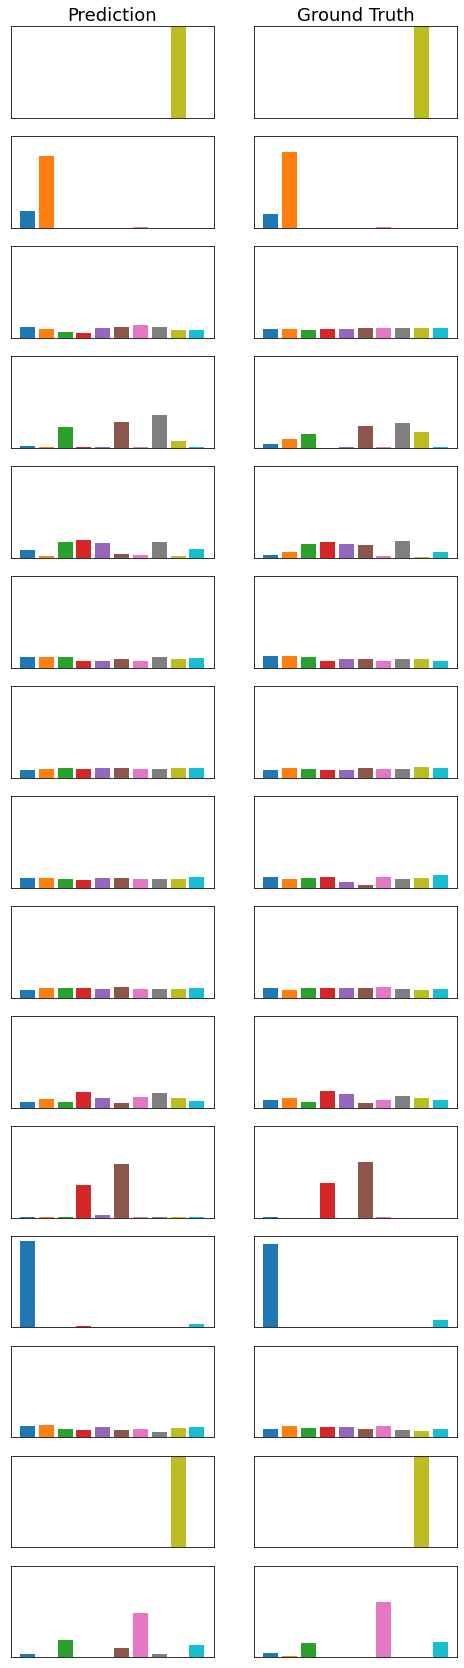

In [230]:
num_plots = 15

fig, axs = plt.subplots(num_plots, 2, figsize=(8, num_plots * 2))

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(10)]

for i in range(num_plots):
    axs[i][0].bar(range(10), pred[i].cpu().numpy(), color=colors)
    axs[i][0].set_ylim(0, 1)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].bar(range(10), y[i].cpu().numpy(), color=colors)
    axs[i][1].set_ylim(0, 1)
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    
axs[0, 0].set_title("Prediction", fontsize=18)
axs[0, 1].set_title("Ground Truth", fontsize=18)

# plt.savefig(os.path.join(args.save_path, "distribution_prediction", "Distribution Comparison MNIST MLP"))